In [1]:
import torch
import torch.nn as nn
import torchvision
import pandas as pd
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
lowImgSize = 64
lowFilter = torchvision.transforms.Compose([torchvision.transforms.Resize(lowImgSize), torchvision.transforms.CenterCrop(lowImgSize), torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((.5, .5, .5), (.5, .5, .5))])

highImgSize = 1024
highFilter = torchvision.transforms.Compose([torchvision.transforms.Resize(highImgSize), torchvision.transforms.CenterCrop(highImgSize), torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((.5, .5, .5), (.5, .5, .5))])

In [3]:
class CarsDataset(torch.utils.data.Dataset):
    def __init__(self, pathName, lowTransforms, highTransforms):
        self.dataset = torchvision.datasets.StanfordCars(pathName, download=True)
        self.lowTransforms = lowTransforms
        self.highTransforms = highTransforms

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        currentImage = self.dataset[index][0]
        lowRes = self.lowTransforms(currentImage)
        highRes = self.highTransforms(currentImage)
        return lowRes, highRes

In [4]:
carDataset = CarsDataset("./dataset", lowFilter, highFilter)

In [5]:
batchSize = 24
numWorkers = 0
loadedData = torch.utils.data.DataLoader(carDataset, batch_size = batchSize, shuffle = True, num_workers = numWorkers)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


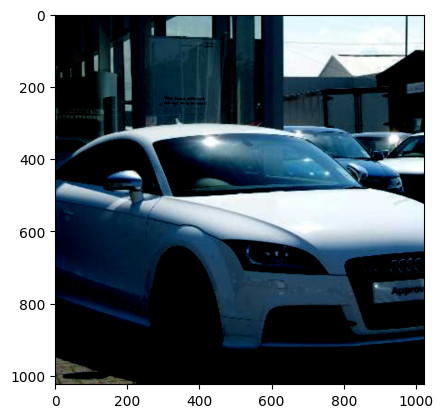

In [6]:
plt.imshow(carDataset[0][1].permute(1, 2, 0))

In [7]:
class SuperRes(nn.Module):
  def __init__(self):
    super(SuperRes, self).__init__()

    self.layer1 = nn.Sequential(
      nn.ConvTranspose2d(3, 16, 4, 2, 1),
      nn.LeakyReLU(0.2),
    )

    self.layer2 = nn.Sequential(
      nn.ConvTranspose2d(16, 32, 4, 2, 1),
      nn.LeakyReLU(0.2),
    )

    self.layer3 = nn.Sequential(
      nn.ConvTranspose2d(32, 64, 4, 2, 1),
      nn.LeakyReLU(0.2),
    )

    self.layer4 = nn.Sequential(
      nn.ConvTranspose2d(64, 3, 4, 2, 1),
      nn.Tanh()
    )

  def forward(self, x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output


In [8]:
device = "cuda"
res = SuperRes().to(device)
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(res.parameters())

In [9]:
eLoss = 0
losses = []
epochs = 100
for epoch in range(epochs):
  for batchx, batchy in tqdm(loadedData):
    batchx, batchy = batchx.to(device), batchy.to(device)
    optim.zero_grad()

    pred = res(batchx)

    loss = loss_fn(pred, batchy)

    loss.backward()

    optim.step()

    eLoss += loss.item()
    losses.append(loss.item())

  print(f"Epoch: {epoch}: eLoss: {eLoss/batchSize}")
  eLoss = 0

100%|██████████| 340/340 [05:20<00:00,  1.06it/s]


Epoch: 0: eLoss: 0.8253974434143553


  0%|          | 0/340 [00:01<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.50 GiB (GPU 0; 8.00 GiB total capacity; 4.55 GiB already allocated; 478.27 MiB free; 6.26 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [10]:
lowResBatch, highResBatch = next(iter(loadedData))
lowResBatch, highResBatch = lowResBatch.to(device), highResBatch.to(device)
highPred = res(lowResBatch)
plt.imshow((highPred[0].cpu().detach().permute(1, 2, 0)+1)/2)

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.50 GiB (GPU 0; 8.00 GiB total capacity; 4.97 GiB already allocated; 446.13 MiB free; 6.26 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

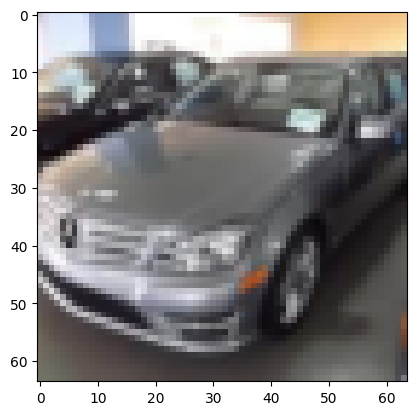

In [ ]:
plt.imshow((lowResBatch[0].cpu().detach().permute(1, 2, 0)+1)/2)

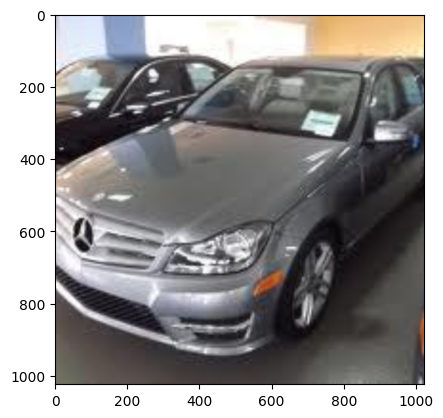

In [ ]:
plt.imshow((highResBatch[0].cpu().detach().permute(1, 2, 0)+1)/2)

In [11]:
lowImgSize = 64
lowFilter = torchvision.transforms.Compose([torchvision.transforms.Resize(lowImgSize), torchvision.transforms.CenterCrop(lowImgSize), torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((.5, .5, .5), (.5, .5, .5))])
plt.imshow((res(lowFilter(Image.open("./image2.png")).to(device)).cpu().detach().permute(1, 2, 0)+1)/2)

FileNotFoundError: [Errno 2] No such file or directory: './image2.png'

In [ ]:
torch.save(res, "./superresSave.model")